In [1]:
from datasets import load_dataset
import os

import uuid
from tqdm import tqdm
import json
import math

import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def make_entity(object_name, bbox, image_width_height,is_bbox_relative=True):
    if not is_bbox_relative:
        bbox = bbox_absolute_to_relative(bbox, image_width_height)
    entity = (object_name, (bbox[0], bbox[1], bbox[2], bbox[3]))
    return entity

In [3]:
def add_loc_to_object_name(object_name_list: list[str], original_w_h_list: list[tuple[int, int]], boxes: list[list[float]], model_type: str = "kosmos2") -> list[str]:
    if model_type == "kosmos2":
        reffer_prefix = "<phrase>"
        reffer_suffix = "</phrase>"
        box_prefix = "<object>"
        box_suffix = "</object>"
        loc_prefix = "<patch_index_"
        loc_suffix = ">"
        image_resized_h_w_size = (224, 224)
        loc_w_h_pixels = (7, 7)
        loc_w_h_num = (int(image_resized_h_w_size[0] / loc_w_h_pixels[0]), int(image_resized_h_w_size[1] / loc_w_h_pixels[1]))

        loc_token_num = loc_w_h_num[0] * loc_w_h_num[1]
        loc_digits = len(str(loc_token_num))
        loc_tokens = ["{}{}{}".format(loc_prefix, str(i).zfill(loc_digits), loc_suffix) for i in range(loc_token_num)]
        loc_tokens_list = [[] for _ in range(loc_w_h_num[1])]  # loc_tokens_list[h][w]で指定する
        for index, h in enumerate(range(loc_w_h_num[1])):
            for w in range(loc_w_h_num[0]):
                item = loc_tokens[index * loc_w_h_num[0] + w]
                loc_tokens_list[h].append(item)

        object_name_list_with_loc = []
        for obj_name, original_w_h, box in zip(object_name_list, original_w_h_list,boxes):

            # floorを使うのは0台なら0,31台なら31にするため
            loc_left_top = [
                int(math.floor(box[0] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[1] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            loc_right_bottom = [
                int(math.floor(box[2] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[3] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            if loc_left_top[0] > loc_w_h_num[0] - 1:
                loc_left_top[0] = loc_w_h_num[0] - 1
            if loc_left_top[1] > loc_w_h_num[1] - 1:
                loc_left_top[1] = loc_w_h_num[1] - 1
            if loc_right_bottom[0] > loc_w_h_num[0] - 1:
                loc_right_bottom[0] = loc_w_h_num[0] - 1
            if loc_right_bottom[1] > loc_w_h_num[1] - 1:
                loc_right_bottom[1] = loc_w_h_num[1] - 1

            object_name_list_with_loc.append(
                f"{reffer_prefix} {obj_name}{reffer_suffix}{box_prefix}{loc_tokens_list[loc_left_top[1]][loc_left_top[0]]}{loc_tokens_list[loc_right_bottom[1]][loc_right_bottom[0]]}{box_suffix}"
            )
        return object_name_list_with_loc
    else:
        raise NotImplementedError(f"model_type {model_type} is not supported")
    
    
def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    bbox_name_list = list(bbox_name_list)
    bbox_list = list(bbox_list)
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    label_id = -1
    old_label = None
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        if old_label != bbox_name:
            label_id += 1
            old_label = bbox_name
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()
    
    
def make_id():
    return str(uuid.uuid4())

def make_sentence(sentence):
    return f"<image><grounding> {sentence}"
    
def make_question_and_answer(sentence):
    question,answer = sentence.split("<object>")
    answer = f"<object>{answer}"    
    return question, answer


def make_conversation(id,image_path,question,answer,gt_entities,image_w_h,ann_id,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ],
        "gt_entities": gt_entities,
        "image_width_height": image_w_h,
        "ann_id": ann_id
    }
    return return_data


In [34]:
dataset_root_dir = "/data_ssd/huggingface_dataset"
cache_dir = "/data_ssd/huggingface_cache"
image_folder_root = "/data_ssd/"
data_split = "test" #"validation" #"train"
huggingface_id = "jxu124/refcocog"
save_json_path = f"/data_ssd/refcoco_g/refcoco_g_kosmos2_{data_split}.json"

dataset_id = os.path.join(dataset_root_dir,huggingface_id)

dataset = load_dataset(dataset_id, cache_dir=cache_dir, split=data_split)

In [35]:
print(dataset[0])
for key, value in dataset[0].items():
    print(f"{key}: {value}")

{'image_id': 380440, 'split': 'test', 'sentences': [{'raw': 'the man in yellow coat', 'sent': 'the man in yellow coat', 'sent_id': 8, 'tokens': ['the', 'man', 'in', 'yellow', 'coat']}, {'raw': 'Skiier in red pants.', 'sent': 'skiier in red pants', 'sent_id': 9, 'tokens': ['skiier', 'in', 'red', 'pants']}], 'file_name': 'COCO_train2014_000000380440_491042.jpg', 'category_id': 1, 'ann_id': 491042, 'sent_ids': [8, 9], 'ref_id': 0, 'raw_anns': '{"segmentation": [[386.14, 222.22, 397.97, 158.85, 436.84, 158.85, 422.47, 133.5, 406.42, 158.85, 382.76, 143.64, 374.31, 140.26, 378.53, 137.73, 399.66, 130.12, 418.25, 110.69, 405.57, 87.03, 411.49, 73.51, 423.32, 65.06, 443.6, 100.55, 462.18, 97.17, 464.72, 111.53, 477.39, 171.52, 481.62, 196.87, 509.5, 253.48, 510.35, 267.0, 479.08, 245.88, 468.94, 233.2, 446.13, 191.8, 419.94, 186.73, 419.94, 208.7, 420.78, 239.96]], "area": 10315.838250000003, "iscrowd": 0, "image_id": 380440, "bbox": [374.31, 65.06, 136.04, 201.94], "category_id": 1, "id": 49

In [36]:
# ann_id_list = []
# for sample in dataset:
#     ann_id_list.append(sample["ann_id"])

In [37]:
print(len(dataset))

5023


In [38]:
# print(len(ann_id_list))
# print(len(dataset))
# print(len(set(ann_id_list)))
# assert len(set(ann_id_list)) == len(dataset), "ann_id_list must be unique"

In [39]:


id_list = []
caption_list = []
bbox_list = []
image_path_list = []
original_image_width_height_list = []
ann_id_list = []

for index, sample in enumerate(tqdm(dataset)):
    ann_id = f"refcoco_g-{index}"
    ids = sample["sent_ids"]
    id_list.extend(ids)

    raw_image_info = json.loads(sample["raw_image_info"])
    caption_list.extend( [sentences["raw"] for sentences in sample["sentences"]])
        
    image_file_name = raw_image_info["file_name"]
    original_image_width_height_list.extend([(raw_image_info["width"], raw_image_info["height"])]*len(ids))
    image_path_list.extend([os.path.join("mscoco2014/train2014",image_file_name)]*len(ids))
    bbox_list.extend([sample["bbox"]]*len(ids))
    ann_id_list.extend([ann_id]*len(ids))
    
assert len(id_list) == len(caption_list) == len(bbox_list) == len(image_path_list) == len(original_image_width_height_list)  == len(ann_id_list), "All lists must have the same length"
    #     sentence_list = add_loc_to_object_name(caption_list, original_image_width_height, [bbox]*len(caption_list), model_type="kosmos2")
    #     question = make_question(caption)
    #     answer = make_answer(bbox, original_image_width_height)
    #     conversation = make_conversation(id,image_path,question,answer)
    #     converted_data.append(conversation)
    # break


100%|██████████| 5023/5023 [00:01<00:00, 3247.01it/s]


In [40]:
print(f"Total number of samples: {len(id_list)}")
index = 0
print(id_list[index])
print(caption_list[index])
print(bbox_list[index])
print(image_path_list[index])
print(original_image_width_height_list[index])
print(ann_id_list[index])

Total number of samples: 9602
8
the man in yellow coat
[374.31, 65.06, 510.35, 267.0]
mscoco2014/train2014/COCO_train2014_000000380440.jpg
(640, 376)
refcoco_g-0


In [41]:


sentence_list = add_loc_to_object_name(caption_list, original_image_width_height_list, bbox_list, model_type="kosmos2")
print(len(sentence_list))
print(sentence_list[index])

9602
<phrase> the man in yellow coat</phrase><object><patch_index_0178><patch_index_0729></object>


the man in yellow coat
[(0.578125, 0.171875, 0.796875, 0.703125)]
[374.31, 65.06, 510.35, 267.0]
[0.584859375, 0.17303191489361702, 0.7974218750000001, 0.7101063829787234]


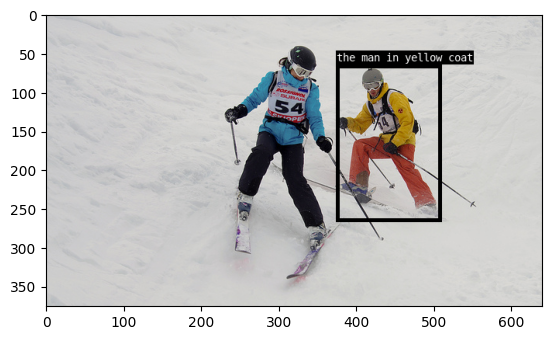

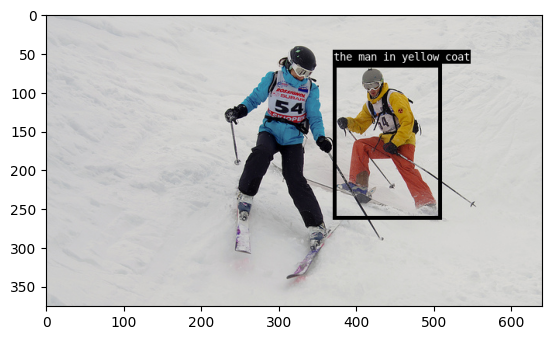

In [42]:

processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
caption, entities = processor.post_process_generation(sentence_list[index])
print(caption)
print(entities[0][2])
print(bbox_list[index])
converted_bbox_list = entities[0][2]
caption = entities[0][0]
print(bbox_absolute_to_relative(bbox_list[index], original_image_width_height_list[index]))
visualize_bbox(os.path.join(image_folder_root,image_path_list[index]), [bbox_list[index]], [caption], bbox_is_relative=False)
visualize_bbox(os.path.join(image_folder_root,image_path_list[index]), converted_bbox_list, [caption], bbox_is_relative=True)


In [43]:
converted_data = []
for id,caption,sentence,bbox,image_path,original_image_width_height,ann_id in tqdm(zip(id_list,caption_list,sentence_list,bbox_list,image_path_list,original_image_width_height_list,ann_id_list), total=len(id_list)):
    id = f"{huggingface_id}-{data_split}-{id}"
    sentence = make_sentence(sentence)
    question,answer = make_question_and_answer(sentence)
    _, entities = processor.post_process_generation(question+answer)
    entity = make_entity(caption, entities[0][-1][0], original_image_width_height,is_bbox_relative=True)
    conversation = make_conversation(id, image_path, question, answer, [entity],original_image_width_height,ann_id)
    converted_data.append(conversation)

100%|██████████| 9602/9602 [00:00<00:00, 40074.26it/s]


In [44]:
print(len(set(image_path_list)))

2600


In [45]:
print("len(converted_data):",len(converted_data))
for i in range(10):
    for key, value in converted_data[i].items():
        print(f"{key}: {value}")
        
for i in range(len(converted_data)-10,len(converted_data)):
    for key, value in converted_data[i].items():
        print(f"{key}: {value}")

len(converted_data): 9602
id: jxu124/refcocog-test-8
image: mscoco2014/train2014/COCO_train2014_000000380440.jpg
conversations: [{'from': 'human', 'value': '<image><grounding> <phrase> the man in yellow coat</phrase>'}, {'from': 'gpt', 'value': '<object><patch_index_0178><patch_index_0729></object>'}]
gt_entities: [('the man in yellow coat', (0.578125, 0.171875, 0.796875, 0.703125))]
image_width_height: (640, 376)
ann_id: refcoco_g-0
id: jxu124/refcocog-test-9
image: mscoco2014/train2014/COCO_train2014_000000380440.jpg
conversations: [{'from': 'human', 'value': '<image><grounding> <phrase> Skiier in red pants.</phrase>'}, {'from': 'gpt', 'value': '<object><patch_index_0178><patch_index_0729></object>'}]
gt_entities: [('Skiier in red pants.', (0.578125, 0.171875, 0.796875, 0.703125))]
image_width_height: (640, 376)
ann_id: refcoco_g-0
id: jxu124/refcocog-test-10
image: mscoco2014/train2014/COCO_train2014_000000419645.jpg
conversations: [{'from': 'human', 'value': '<image><grounding> <ph

In [46]:

if not os.path.exists(os.path.dirname(save_json_path)):
    os.makedirs(os.path.dirname(save_json_path))
with open(save_json_path, "w") as f:
    json.dump(converted_data, f, indent=4, ensure_ascii=False)

In [47]:
with open(save_json_path, "r") as f:
    loaded_data = json.load(f)
print("len(loaded_data):",len(loaded_data))

len(loaded_data): 9602


In [48]:
image_folder_root = "/data_ssd"

exist_image_count = 0
for i in tqdm(range(len(loaded_data))):
    image_file_name = loaded_data[i]["image"]
    image_path = os.path.join(image_folder_root,image_file_name)
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue
    exist_image_count += 1
print("exist_image_count:", exist_image_count)
print("non_exist_image_count:", len(loaded_data) - exist_image_count)
print("exist_image_count / len(loaded_data):", exist_image_count / len(loaded_data))

100%|██████████| 9602/9602 [00:00<00:00, 22139.05it/s]

exist_image_count: 9602
non_exist_image_count: 0
exist_image_count / len(loaded_data): 1.0
